#DATASCI W261, Machine Learning at Scale
--------
####Assignement:  week \#9
####[Lei Yang](mailto:leiyang@berkeley.edu) | [Michael Kennedy](mailto:mkennedy@ischool.berkeley.edu) | [Natarajan Krishnaswami](mailto:natarajan@krishnaswami.org)
####Due: 2016-03-19, 12PM PST

###HW 9.0: Short answer questions

What is PageRank and what is it used for in the context of web search?
What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?
OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)


###HW 9.1: MRJob implementation of basic PageRank

- Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
- Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, **distributes the mass of dangling nodes with each iteration**
so that the output of each iteration is correctly normalized (sums to 1).
- [**NOTE**: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016

###PageRank Iteration Job
- **mapper**: use counter to get node count; get node struct
- **reducer_job_init**: the loss mass count also equals to the number of dangling nodes

In [52]:
%%writefile PageRankIter.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankIter(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankIter, self).configure_options()        
        self.add_passthrough_option(
            '--i', dest='init', default='0', type='int',
            help='i: run initialization iteration (default 0)')    

    def mapper_job_init(self, _, line):        
        # parse line
        nid, adj = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'adj = %s' %adj
        exec cmd
        # initialize node struct        
        node = {'a':adj.keys(), 'p':0}
        rankMass = 1.0/len(adj)
        # emit node
        yield nid, node
        # emit pageRank mass        
        for m in node['a']:
            yield m, rankMass
            
    def mapper_job_iter(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # distribute rank mass  
        n_adj = len(node['a'])
        if n_adj > 0:
            rankMass = 1.0*node['p'] / n_adj
            # emit pageRank mass        
            for m in node['a']:
                yield m, rankMass
        else:
            # track dangling mass with counter
            self.increment_counter('wiki_dangling_mass', 'mass', int(node['p']*1e10))
        # reset pageRank and emit node
        node['p'] = 0
        yield nid, node
    
    def debug(self):
        de = 'bug'
                
    # write a separate combiner ensure the integrity of the graph topology
    # no additional node object will be generated
    def combiner(self, nid, value):             
        rankMass, node = 0.0, None        
        # loop through all arrivals
        for v in value:            
            if isinstance(v, float):
                rankMass += v                
            else:
                node = v            
        # emit accumulative mass for nid       
        if node:
            node['p'] += rankMass
            yield nid, node
        else:
            yield nid, rankMass
    
    # reducer for initialization pass --> need to handle dangling nodes
    def reducer_job_init(self, nid, value):      
        # increase counter for node count
        self.increment_counter('wiki_node_count', 'nodes', 1)
        rankMass, node = 0.0, None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, float):
                rankMass += v         
            else:
                node = v
        # handle dangling node, create node struct and add missing mass
        if not node:            
            node = {'a':[], 'p':rankMass}            
            self.increment_counter('wiki_dangling_mass', 'mass', int(1e10))
        else:
            node['p'] += rankMass            
        # emit for next iteration
        yield nid, node
        
    # reducer for regular pass --> all nodes has structure available
    def reducer_job_iter(self, nid, value):              
        rankMass, node = 0.0, None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, float):
                rankMass += v         
            else:
                node = v
        # update pageRank
        node['p'] += rankMass            
        # emit for next iteration
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper_job_init if self.options.init else self.mapper_job_iter                       
                       , combiner=self.combiner                       
                       , reducer=self.reducer_job_init if self.options.init else self.reducer_job_iter
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankIter.run()


Overwriting PageRankIter.py


In [1]:
##### unit test #####
#!python PageRankIter.py ./data/PageRank-test.txt --i 1 -r 'inline'  > iter1.t
#!python PageRankIter.py iter8.t --i 0 -r 'inline' > iter9.t
#!python PageRankIter.py 'hdfs:///user/leiyang/PageRank-test.txt' --i 1 -r 'hadoop' --output-dir 's3://w261.data/HW9_test' 

###PageRankDist Job
- applying damping and random jump factor
- redistribute dangling mass across the graph
- note: normalize the ranking number at last iteration

In [53]:
%%writefile PageRankDist.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankDist(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankDist, self).configure_options()        
        self.add_passthrough_option(
            '--s', dest='size', default=0, type='int',
            help='size: node number (default 0)')    
        self.add_passthrough_option(
            '--j', dest='alpha', default=0.15, type='float',
            help='jump: random jump factor (default 0.15)') 
        self.add_passthrough_option(
            '--n', dest='norm', default=0, type='int',
            help='norm: normalize pageRank with graph size (default 0)') 
        self.add_passthrough_option(
            '--m', dest='m', default=0, type='float',
            help='m: rank mass from dangling nodes (default 0)') 
    
    def mapper_init(self):
        self.damping = 1 - self.options.alpha        
        self.p_dangling = self.options.m / self.options.size        
    
    # needed after initialization, after node number becomes available
    def mapper_norm(self, _, line):        
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank      
        node['p'] = ((self.p_dangling + node['p'])*self.damping+self.options.alpha) / self.options.size
        yield nid, node
            
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank      
        node['p'] = (self.p_dangling + node['p']) * self.damping + self.options.alpha
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',           
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper_norm if self.options.norm else self.mapper                       
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankDist.run()


Overwriting PageRankDist.py


In [267]:
##### unit test #####

#!python PageRankIter.py ./data/PageRank-test.txt --i 1 -r 'inline'  > iter1.t
#!python PageRankIter.py iter8.t --i 0 -r 'inline' > iter9.t


#!python PageRankDist.py iter1.t --n 0 --s 11 --j 0.15 --m 1.0 > iter2.t
#!python PageRankDist.py iter9.t --n 0 --s 11 --j 0.15 --m 0.41355561274607455   > iter10.t

###PageRankSort Job
- sort pageRank with descending order

In [54]:
%%writefile PageRankSort.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankSort(MRJob):
    #DEFAULT_PROTOCOL = 'json'   
    
    def configure_options(self):
        super(PageRankSort, self).configure_options()        
        self.add_passthrough_option(
            '--s', dest='size', default=0, type='int',
            help='size: node number (default 0)')
        self.add_passthrough_option(
            '--n', dest='top', default=100, type='int',
            help='size: node number (default 100)')
    
    def mapper(self, _, line):        
        # parse line
        nid, node = line.strip().split('\t', 1)
        cmd = 'node = %s' %node
        exec cmd        
        yield node['p'], nid.strip('"')
    
    def reducer_init(self):        
        self.i = 0
        self.total = 0
    
    def reducer(self, pageRank, nid): 
        for n in nid:
            if self.i < self.options.top:
                self.i += 1
                self.total += pageRank
                yield n, pageRank/self.options.size
            
    def reducer_final(self):
        yield 'total mass: ', self.total/self.options.size

    def steps(self):
        jc = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1nr',
            'mapreduce.job.maps': '2', 
            'mapreduce.job.reduces': '1',  # must be 1 for sorting
        }
        return [MRStep(mapper=self.mapper, reducer_init=self.reducer_init, 
                       reducer=self.reducer, reducer_final=self.reducer_final
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankSort.run()


Overwriting PageRankSort.py


In [290]:
##### unit test #####
#!python PageRankSort.py iter10.t --s 11 --n 100 -r 'hadoop'

###PageRankJoin Job
- find page name from index file for the top ranked pages

In [55]:
%%writefile PageRankJoin.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankJoin(MRJob):
    #DEFAULT_PROTOCOL = 'json'   
    
    def mapper_init(self):
        self.topRanks = {}
        # read rand list, prepare for mapper in-memory join        
        cat = Popen(['cat', 'part-00000'], stdout=PIPE)
        for line in cat.stdout:
            nid, rank = line.strip().split('\t')
            self.topRanks[nid.strip('"')] = rank
    
    def mapper(self, _, line):        
        # parse line
        name, nid, d_in, d_out = line.strip().split('\t')
        if nid in self.topRanks:                        
            yield float(self.topRanks[nid]), '%s - %s' %(nid, name)
    
    def reducer(self, key, value):
        for v in value:
            yield key, v
    

    def steps(self):
        jc = {            
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1nr',
            'mapreduce.job.maps': '2', 
            'mapreduce.job.reduces': '1',  # must be 1 for sorting            
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankJoin.run()



Overwriting PageRankJoin.py


In [26]:
##### unit test #####
#!python PageRankJoin.py 'PageRankIndex' -r 'hadoop' --file 'rank' #> test.t

###Helpers

In [4]:
%%writefile helper.py
#!/usr/bin/python

import requests

def getCounter(groupName, counterName, host = 'localhost'):
    # get job list       
    getJobs = 'http://%s:19888/ws/v1/history/mapreduce/jobs' %host
    jobs = requests.get(getJobs).json()['jobs']['job'] 
    # get counters
    ts = max([job['finishTime'] for job in jobs])
    id = [job['id'] for job in jobs if job['finishTime'] == ts][0]
    getCounters = 'http://%s:19888/ws/v1/history/mapreduce/jobs/%s/counters' %(host, id)
    counterGroups = requests.get(getCounters).json()['jobCounters']['counterGroup']
    # loop through to counters to return value
    counters = [g['counter'] for g in counterGroups if g['counterGroupName']==groupName][0]
    totalValues = [c['totalCounterValue'] for c in counters if c['name']==counterName]
    return totalValues[0] if len(totalValues)==1 else None

def getCounters(groupName, host = 'localhost'):
    # get job list       
    getJobs = 'http://%s:19888/ws/v1/history/mapreduce/jobs' %host
    jobs = requests.get(getJobs).json()['jobs']['job'] 
    # get counters
    ts = max([job['finishTime'] for job in jobs])
    id = [job['id'] for job in jobs if job['finishTime'] == ts][0]
    getCounters = 'http://%s:19888/ws/v1/history/mapreduce/jobs/%s/counters' %(host, id)
    counterGroups = requests.get(getCounters).json()['jobCounters']['counterGroup']
    # loop through to counters to return value
    counters = [g['counter'] for g in counterGroups if g['counterGroupName']==groupName]    
    return {c['name']:c['totalCounterValue'] for c in counters[0]} if len(counters)==1 else []
    

Overwriting helper.py


In [7]:
##### unit test #####
#http://localhost:19888/ws/v1/history/mapreduce/jobs/job_1457742616221_0001/counters
#from helper import getCounter, getCounters
#getCounter('wiki_node_count', 'nodes', 'ec2-52-87-184-124.compute-1.amazonaws.com')
#getCounters('wiki_dangling_mass')
#getCounter('org.apache.hadoop.mapreduce.JobCounter', 'TOTAL_LAUNCHED_MAPS')
#getCounters('org.apache.hadoop.mapreduce.JobCounter', 'ec2-54-172-84-241.compute-1.amazonaws.com')

{u'mass_0': 10000000000,
 u'mass_1': 10000000000,
 u'mass_10': 10000000000,
 u'mass_2': 10000000000,
 u'mass_3': 10000000000,
 u'mass_4': 10000000000,
 u'mass_5': 10000000000,
 u'mass_6': 10000000000,
 u'mass_7': 10000000000,
 u'mass_8': 10000000000,
 u'mass_9': 10000000000}

###PageRank Driver
- initialize the process: 
 - get node count, and dangling node count
 - redistribute loss mass, apply jump/damping factor
- get loss mass from counter
- iterately execute pageRank:
 - run pageRank process
 - get loss mass
- sort rank, normalize

In [56]:
%%writefile RunPageRank.py
#!/usr/bin/python

from PageRankIter import PageRankIter
from PageRankDist import PageRankDist
from PageRankSort import PageRankSort
from PageRankJoin import PageRankJoin
from helper import getCounter
from subprocess import call, check_output
from time import time
import sys, getopt, datetime, os

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "hg:j:i:d:s:")
    except getopt.GetoptError:
        print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index> -s <size>'
        sys.exit(2)
    if len(opts) != 5:
        print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index>'
            sys.exit(2)
        elif opt == '-g':
            graph = arg
        elif opt == '-j':
            jump = arg
        elif opt == '-i':            
            n_iter = arg
        elif opt == '-d':
            index = arg
        elif opt == '-s':
            n_node = arg
        
start = time()
FNULL = open(os.devnull, 'w')
n_iter = int(n_iter)
doJoin = index!='NULL'
doInit = n_node=='0'
host = 'localhost'

print '%s: %s PageRanking on \'%s\' for %d iterations with damping factor %.2f ...' %(str(datetime.datetime.now()),
          'start' if doInit else 'continue', graph[graph.rfind('/')+1:], n_iter, 1-float(jump))

if doInit:
    # clear directory
    print str(datetime.datetime.now()) + ': clearing directory ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/out'], stdout=FNULL)
    
    # creat initialization job    
    init_job = PageRankIter(args=[graph, '--i', '1', '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])

    # run initialization job
    print str(datetime.datetime.now()) + ': running iteration 1 ...'
    with init_job.make_runner() as runner:    
        runner.run()

    # checking counters
    n_node = getCounter('wiki_node_count', 'nodes', host)
    n_dangling = getCounter('wiki_dangling_mass', 'mass', host)/1e10
    print '%s: initialization complete: %d nodes, %d are dangling!' %(str(datetime.datetime.now()), n_node, n_dangling)

    # run redistribution job
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])
    dist_job = PageRankDist(args=['hdfs:///user/leiyang/in/part*', '--s', str(n_node), '--j', jump, '--n', '0', 
                                '--m', str(n_dangling), '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()

# move results for next iteration
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])

# create iteration job
iter_job = PageRankIter(args=['hdfs:///user/leiyang/in/part*', '--i', '0', 
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])

# run pageRank iteratively
i = 2 if doInit else 1
while(1):
    print str(datetime.datetime.now()) + ': running iteration %d ...' %i
    with iter_job.make_runner() as runner:        
        runner.run()
    
    # check counter for loss mass
    mass_loss = getCounter('wiki_dangling_mass', 'mass', host)/1e10
    
    # move results for next iteration
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])
        
    # run redistribution job
    dist_job = PageRankDist(args=['hdfs:///user/leiyang/in/part*', '--s', str(n_node), '--j', jump, '--n', '0', 
                                '--m', str(mass_loss), '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])
    print str(datetime.datetime.now()) + ': distributing loss mass %.4f ...' %mass_loss
    with dist_job.make_runner() as runner:    
        runner.run()
    
    if i == n_iter:
        break
    
    # if more iteration needed
    i += 1    
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'], stdout=FNULL)

# run sort job
print str(datetime.datetime.now()) + ': sorting PageRank ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/rank'], stdout=FNULL)
sort_job = PageRankSort(args=['hdfs:///user/leiyang/out/part*', '--s', str(n_node), '--n', '100',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/rank'])
with sort_job.make_runner() as runner:    
    runner.run()
    
# run join job
if doJoin:
    print str(datetime.datetime.now()) + ': joining PageRank with index ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/join'], stdout=FNULL)
    join_job = PageRankJoin(args=[index, '-r', 'hadoop', '--file', 'hdfs:///user/leiyang/rank/part-00000', 
                                  '--output-dir', 'hdfs:///user/leiyang/join'])
    with join_job.make_runner() as runner:
        runner.run()

print "%s: PageRank job completes in %.1f minutes!\n" %(str(datetime.datetime.now()), (time()-start)/60.0)
call(['hdfs', 'dfs', '-cat', '/user/leiyang/join/p*' if doJoin else '/user/leiyang/rank/p*', '>', 'results_wiki_50'])

Overwriting RunPageRank.py


In [57]:
##### unit test #####
!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 0.15 -i 3 -d 'NULL' -s '0'

#!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 0.15 -i 2 \
#-d 'hdfs:///user/leiyang/PageRankIndex' -s '11'

2016-03-18 20:00:07.249470: start PageRanking on 'PageRank-test.txt' for 3 iterations with damping factor 0.85 ...
2016-03-18 20:00:07.249520: clearing directory ...
2016-03-18 20:00:10.345712: running iteration 1 ...
No handlers could be found for logger "mrjob.conf"
2016-03-18 20:00:41.777593: initialization complete: 11 nodes, 1 are dangling!
2016-03-18 20:00:43.326969: distributing loss mass ...
2016-03-18 20:01:12.047432: running iteration 2 ...
2016-03-18 20:01:46.734200: distributing loss mass 0.6523 ...
2016-03-18 20:02:15.239642: running iteration 3 ...
2016-03-18 20:02:50.117925: distributing loss mass 0.4174 ...
2016-03-18 20:03:13.465448: sorting PageRank ...
2016-03-18 20:03:44.107520: PageRank job completes in 3.6 minutes!

"B"	0.4072918072992323
"C"	0.23815584801755094
"E"	0.1182189428071322
"A"	0.06401906959302478
"F"	0.04473570130275573
"D"	0.04473570130275573
"J"	0.016568585934338843
"H"	0.016568585934338843
"K"	0.016568585934338843
"I"	0.016568585934338843
"G"	0.0165

###HW 9.2: Exploring PageRank teleportation and network plots
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW 9.1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: $[0,0.25,0.5,0.75, 0.85, 1]$. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [33]:
%load_ext autoreload
%autoreload 2
#!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 1 -i 3 -d 'NULL'  -s '0'
#!hdfs dfs -cat /user/leiyang/rank/p* > HW_9_2_0
#!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 0.75 -i 10 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/leiyang/rank/p* > HW_9_2_1
#!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 0.5 -i 10 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/leiyang/rank/p* > HW_9_2_2
#!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 0.25 -i 10 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/leiyang/rank/p* > HW_9_2_3
#!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 0.15 -i 10 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/leiyang/rank/p* > HW_9_2_4
#!python RunPageRank.py -g 'hdfs:///user/leiyang/PageRank-test.txt' -j 0 -i 10 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/leiyang/rank/p* > HW_9_2_5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


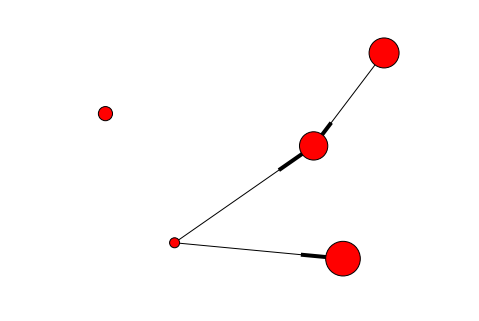

In [45]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
G=nx.DiGraph()
pos=nx.spring_layout(G) # positions for all nodes

G.add_node("spam")
G.add_node("ham")
G.add_node("test", name='test')
G.add_nodes_from(['rory', 'jason'])
G.add_edge("spam","ham")
G.add_edge('test','ham')
G.add_edge('test','rory')



nx.draw(G, node_size=[100,200,800,1200,900])

plt.show()

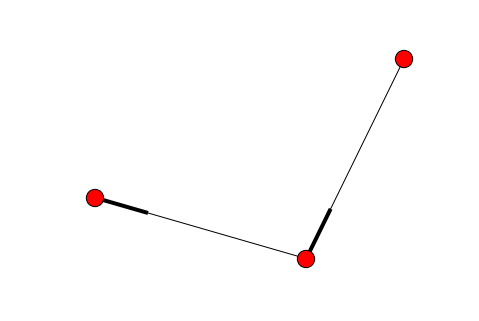

In [51]:
from matplotlib import pyplot as plt
import networkx as nx
G = nx.DiGraph()
G.add_edge('rory','jordan')
G.add_edge('jordan','jason')
#G.add_node('rory')
#G.add_node('jason')
#G.add_node('jordan')
G.node['jordan']['state']='jordan'
G.node['rory']['state']='rory'
G.node['jason']['state']='jason'

#for n in G.edges_iter():
#    G.edge[n[0]][n[1]]['state']='X'
#G.edge[2][3]['state']='Y'

pos = nx.spring_layout(G)

nx.draw(G, pos)
#node_labels = nx.get_node_attributes(G,'state')
#nx.draw_networkx_labels(G, pos, labels = node_labels)
#edge_labels = nx.get_edge_attributes(G,'state')
#nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
#plt.savefig('this.png')
plt.show()

###HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

- Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).
- Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 

- Have the top 100 ranked pages changed? 
 - Comment on your findings. 
 - Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. 
 - Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  
 
### Top 100 PageRank on 10 iterations

In [108]:
#!python RunPageRank.py -g 'hdfs:///user/leiyang/all-pages-indexed-out.txt' -j 0.15 -i 10 \
#-d 'hdfs:///user/leiyang/indices.txt' -s '0'
!cat ./data/wiki_10_join

0.0014614491942438349	"13455888 - United States"
0.0006663317375798755	"1184351 - Animal"
0.0006398051875506791	"4695850 - France"
0.0005748538826286757	"5051368 - Germany"
0.0004503047142785041	"1384888 - Arthropod"
0.00044660099098876925	"2437837 - Canada"
0.0004448182480165896	"6113490 - Insect"
0.000444203734598283	"7902219 - List of sovereign states"
0.0004329952449265189	"13425865 - United Kingdom"
0.000427885336130834	"6076759 - India"
0.00042327595490625425	"4196067 - England"
0.00039817029586927596	"6172466 - Iran"
0.0003854336708092153	"14112583 - World War II"
0.0003631670660462813	"10390714 - Poland"
0.00034383110763123157	"15164193 - village"
0.0003383478652193903	"3191491 - Countries of the world"
0.0003293524626579213	"6416278 - Japan"
0.00032896996556415974	"6237129 - Italy"
0.00032632071986423984	"7835160 - List of countries"
0.0003250758881557822	"1516699 - Australia"
0.0003131434418030617	"13725487 - Voivodeships of Poland"
0.0003095941242456258	"9276255 - National R

### Top 100 PageRank on 50 iterations

In [109]:
#!python RunPageRank.py -g 'hdfs:///user/leiyang/all-pages-indexed-out.txt' -j 0.15 -i 50 \
#-d 'hdfs:///user/leiyang/indices.txt' -s '0'
!cat ./data/wiki_50_join

0.0014615599816380814	"13455888 - United States"
0.0006660177936038597	"1184351 - Animal"
0.0006396773757180422	"4695850 - France"
0.0005747671982893716	"5051368 - Germany"
0.0004501232221973807	"1384888 - Arthropod"
0.00044667005168115624	"2437837 - Canada"
0.00044463224402460465	"6113490 - Insect"
0.00044387869965694206	"7902219 - List of sovereign states"
0.00043314218173262273	"13425865 - United Kingdom"
0.00042770776770628867	"6076759 - India"
0.00042341679596246464	"4196067 - England"
0.000397826042012343	"6172466 - Iran"
0.00038548623796188223	"14112583 - World War II"
0.00036266653367941786	"10390714 - Poland"
0.00034358745300642004	"15164193 - village"
0.0003380496128621886	"3191491 - Countries of the world"
0.0003292203268728178	"6416278 - Japan"
0.00032899474579557773	"6237129 - Italy"
0.00032620175381522067	"7835160 - List of countries"
0.00032511085571704744	"1516699 - Australia"
0.00031268227722189133	"13725487 - Voivodeships of Poland"
0.0003095692741012243	"9276255 - Na

###Comments
- the top 100 node are identical except for two of them swapped their place ("9391762 - New York" and "2614578 - Central European Summer Time")
- convergence is pretty fast for this graph with wiki nodes

###HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the **top ten** ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of **0.15** in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

$v_{ji} = \frac{\beta}{|T_j|}$; if node $i$ lies in topic $T_j$

$v_{ji} = \frac{1-\beta}{N - |Tj|}$; if node $i$ lies outside of topic $T_j$

for $\beta$ in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If $\beta > 0.5$, PageRank is topic-sensitive, 
and if $\beta < 0.5$, the PageRank is anti-topic-sensitive. 
For any value of $\beta$ irreducibility should hold,
so please try $\beta=0.99$, and perhaps some other values locally,
on the smaller networks.


### Implementation Notes - two changes on the vanilla PageRank implementation:

####1. during mass distribution step, in _PageRankIter_ job:
 - maintain an array of ranks for each topic
 - distribute and accumulate rank number separately for each rank number


In [112]:
%%writefile PageRankIter_T.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankIter_T(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankIter_T, self).configure_options()        
        self.add_passthrough_option(
            '--i', dest='init', default='0', type='int',
            help='i: run initialization iteration (default 0)') 
        self.add_passthrough_option(
            '--n', dest='n_topic', default='0', type='int',
            help='n: number of topics (default 0)') 

    def mapper_job_init(self, _, line):        
        # parse line
        nid, adj = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'adj = %s' %adj
        exec cmd
        # initialize node struct        
        node = {'a':adj.keys(), 'p':[0]*(self.options.n_topic + 1)}
        # vanillar PageRank and topic sensitive PageRank
        rankMass = [1.0 / len(adj)] * (self.options.n_topic + 1)
        # emit node
        yield nid, node
        # emit pageRank mass        
        for m in node['a']:
            yield m, rankMass
            
    def mapper_job_iter(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # distribute rank mass  
        n_adj = len(node['a'])
        if n_adj > 0:
            rankMass = [x / n_adj for x in node['p']]
            # emit pageRank mass        
            for m in node['a']:
                yield m, rankMass
        else:
            # track dangling mass for each topic with counters
            for i in range(self.options.n_topic+1):
                self.increment_counter('wiki_dangling_mass', 'topic_%d' %i, int(node['p'][i]*1e10))
        # reset pageRank and emit node
        node['p'] = [0]*(self.options.n_topic+1)
        yield nid, node
    
    def debug(self):
        de = 'bug'
                
    # write a separate combiner ensure the integrity of the graph topology
    # no additional node object will be generated
    def combiner(self, nid, value):             
        rankMass, node = [0]*(self.options.n_topic+1), None        
        # loop through all arrivals
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]                
            else:
                node = v            
        # emit accumulative mass for nid       
        if node:
            node['p'] = [a+b for a,b in zip(rankMass, node['p'])]
            yield nid, node
        else:
            yield nid, rankMass
    
    # reducer for initialization pass --> need to handle dangling nodes
    def reducer_job_init(self, nid, value):      
        # increase counter for node count
        self.increment_counter('wiki_node_count', 'nodes', 1)
        rankMass, node = [0]*(self.options.n_topic+1), None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]         
            else:
                node = v
        # handle dangling node, create node struct and add missing mass
        if not node:            
            node = {'a':[], 'p':rankMass}   
            for i in range(self.options.n_topic+1):
                self.increment_counter('wiki_dangling_mass', 'mass_%d' %i, int(1e10))
        else:
            node['p'] = [a+b for a,b in zip(rankMass, node['p'])]
        # emit for next iteration
        yield nid, node
        
    # reducer for regular pass --> all nodes has structure available
    def reducer_job_iter(self, nid, value):              
        rankMass, node = [0]*(self.options.n_topic+1), None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]        
            else:
                node = v
        # update pageRank
        node['p'] = [a+b for a,b in zip(rankMass, node['p'])]            
        # emit for next iteration
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper_job_init if self.options.init else self.mapper_job_iter                       
                       , combiner=self.combiner                       
                       , reducer=self.reducer_job_init if self.options.init else self.reducer_job_iter
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankIter_T.run()


Overwriting PageRankIter_T.py


In [9]:
##### unit test #####
#!python PageRankIter_T.py ./data/randNet.txt --i 1 --n 10 -r 'inline' > test.t
#!python PageRankIter_T.py ./data/PageRank-test.txt --i 1 --n 10 -r 'hadoop' > test.t
#!python PageRankIter_T.py test.t --i 0 --n 2 -r 'inline' > test2.t

####2. during mass redistribution/adjustment step, in _PageRankDist_ job:
 
$$p'=\alpha\big(\frac{1}{|G|}\big)+(1-\alpha)\big(\frac{m}{|G|}+p\big),\quad |G|=N$$

  - instead of all nodes receiving $\frac{1}{N}$ uniformly in the teleportation term, nodes belong to topic $T_j$ will receive $\frac{\beta}{|T_j|}$, and others receive $\frac{1-\beta}{N - |Tj|}$
  

  - intuitively with $\beta=0.99$, the teleportation will transition to nodes in $T_j$ with a $99\%$ probability, while only $1\%$ chance to nodes outside of $T_j$


  - because $\beta$ and $|T_j|$ are both known, we will evaluate $v_{ji}$ before hand and load all $10$ of them in _mapper_init_ phase, and apply it in the mapper.

In [12]:
%%writefile PageRankDist_T.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankDist_T(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankDist_T, self).configure_options()        
        self.add_passthrough_option(
            '--s', dest='size', default=0, type='int',
            help='size: node number (default 0)')    
        self.add_passthrough_option(
            '--j', dest='alpha', default=0.15, type='float',
            help='jump: teleport factor (default 0.15)') 
        self.add_passthrough_option(
            '--b', dest='beta', default=0.99, type='float',
            help='beta: topic bias factor (default 0.99)') 
        self.add_passthrough_option(
            '--m', dest='m', default='', type='str',
            help='m: rank mass from dangling nodes') 
        self.add_passthrough_option(
            '--w', dest='wiki', default=0, type='int',
            help='w: if it is wiki data (default 1)') 
    
    def mapper_init(self):
        # load topic file and count
        T_j, self.T_index = {}, {}
        cat = Popen(['cat', 'randNet_topics.txt'], stdout=PIPE)
        for line in cat.stdout:
            nid, topic = line.strip().split('\t')
            self.T_index[nid] = topic
            T_j[topic] = 1 if topic not in T_j else (T_j[topic]+1)
            
        # prepare adjustment factors
        self.damping = 1 - self.options.alpha        
        cmd = 'm = %s' %self.options.m
        exec cmd
        # assuming here -m is specified with a list syntax string
        self.p_dangling = [1.0*x / self.options.size for x in m]
        # for each topic, get topic bias
        self.v_ij = [[1, 1]]*(len(T_j)+1)
        N, b = self.options.size, self.options.beta
        for t in T_j:
            self.v_ij[int(t)] = [(1-b)*N/(N-T_j[t]), b*N/T_j[t]]
                
            
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank        
        for i in range(len(self.v_ij)):
            vij = self.v_ij[i][i==int(self.T_index[nid])]
            node['p'][i] = (self.p_dangling[i]+node['p'][i])*self.damping + self.options.alpha*vij
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',           
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper                    
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankDist_T.run()


Overwriting PageRankDist_T.py


In [11]:
##### unit test #####
# no dangling nodes for randNet data
#!python PageRankDist_T.py test.t --m '[1]*11' --s '100' --file './data/randNet_topics.txt'  -r 'hadoop' > test2.t

###PageRankSort job 
- emit (vector_ID, pageRank)~topic_id as key~value pair
- partition on vector_ID, secondary sort (-k2,2nr) on pageRank 
- print out top 10 for each vector_ID

In [2]:
%%writefile PageRankSort_T.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankSort_T(MRJob):
    DEFAULT_PROTOCOL = 'json'
    PARTITIONER = 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
    
    def mapper_init(self):
        # load topic file and count
        self.T_index = {}
        cat = Popen(['cat', 'randNet_topics.txt'], stdout=PIPE)
        for line in cat.stdout:
            nid, topic = line.strip().split('\t')
            self.T_index[nid] = topic                
            
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # emit (vector_ID, pageRank)~topic_id
        for i in range(len(node['p'])):
            yield (i, node['p'][i]), self.T_index[nid]
        
    def reducer_init(self):
        self.current_v = None
        self.i = 0
        self.top = 10
    
    def reducer(self, key, value):
        if self.current_v != key[0]:
            self.current_v = key[0]
            self.i = 0
            yield '====== Top 10 for topic %d ======' %self.current_v, ''
        if self.i < self.top:
            self.i += 1
            for v in value:
                yield key, v
        
    
    def steps(self):
        jc = {
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '3',            
            'mapreduce.partition.keypartitioner.options': '-k1,1',             
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2nr',            
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',   
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper     
                       , reducer_init=self.reducer_init
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankSort_T.run()



Overwriting PageRankSort_T.py


In [40]:
##### unit test #####
#!python PageRankSort_T.py 'randNet_pr' --file './data/randNet_topics.txt' -r 'hadoop' > test.sort2

###Driver for topic-sensitive-pagerank
- we need to retrieve a group of counters, which represent loss mass for each topic. 
- in this implementation, the counter group name is **wiki_dangling_mass**, and counter names are **mass_[i]**, with mass_0 for vanilla pageRank, and mass_1 for topic 1 etc.
- the loss values are passed as list syntax string to the job, which will transfer it to a list

In [47]:
%%writefile RunPageRank_T.py
#!/usr/bin/python

from PageRankIter_T import PageRankIter_T
from PageRankDist_T import PageRankDist_T
from PageRankSort_T import PageRankSort_T
from PageRankJoin import PageRankJoin
from helper import getCounter, getCounters
from subprocess import call, check_output
from time import time
import sys, getopt, datetime, os

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "hg:j:i:d:s:")
    except getopt.GetoptError:
        print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index> -s <size>'
        sys.exit(2)
    if len(opts) != 5:
        print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index>'
            sys.exit(2)
        elif opt == '-g':
            graph = arg
        elif opt == '-j':
            jump = arg
        elif opt == '-i':            
            n_iter = arg
        elif opt == '-d':
            index = arg
        elif opt == '-s':
            n_node = arg
        
start = time()
FNULL = open(os.devnull, 'w')
n_iter = int(n_iter)
doJoin = index!='NULL'
doInit = n_node=='0'
host = 'localhost'

print '%s: %s topic sensitive PageRanking on \'%s\' for %d iterations with damping factor %.2f ...' %(str(datetime.datetime.now()),
          'start' if doInit else 'continue', graph[graph.rfind('/')+1:], n_iter, 1-float(jump))

if doInit:
    # clear directory
    print str(datetime.datetime.now()) + ': clearing directory ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/out'], stdout=FNULL)
    
    # creat initialization job    
    init_job = PageRankIter_T(args=[graph, '--i', '1', '--n', '10', '-r', 'hadoop', 
                                    '--output-dir', 'hdfs:///user/leiyang/out'])

    # run initialization job
    print str(datetime.datetime.now()) + ': running iteration 1 ...'
    with init_job.make_runner() as runner:    
        runner.run()

    # checking counters
    n_node = getCounter('wiki_node_count', 'nodes', host)    
    loss = getCounters('wiki_dangling_mass', host)
    loss_array = ['0']*11
    for k in loss:
        i = int(k.split('_')[1])
        loss_array[i] = str(loss[k]/1e10)
    print '%s: initialization complete: %d nodes!' %(str(datetime.datetime.now()), n_node)

    # run redistribution job
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])
    loss_param = '[%s]' %(','.join(['0']*11) if len(loss)==0 else ','.join(loss_array))
    dist_job = PageRankDist_T(args=['hdfs:///user/leiyang/in/part*', '--s', str(n_node), '--m', loss_param,
                                    '--file', 'hdfs:///user/leiyang/randNet_topics.txt',
                                    '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()

# move results for next iteration
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])

# create iteration job
iter_job = PageRankIter_T(args=['hdfs:///user/leiyang/in/part*', '--i', '0', '--n', '10',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])

# run pageRank iteratively
i = 2 if doInit else 1
while(1):
    print str(datetime.datetime.now()) + ': running iteration %d ...' %i
    with iter_job.make_runner() as runner:        
        runner.run()
    
    # check counters for topic loss mass
    loss = getCounters('wiki_dangling_mass', host)
    loss_array = ['0']*11
    for k in loss:
        i = int(k.split('_')[1])
        loss_array[i] = str(loss[k]/1e10)
    
    # move results for next iteration
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])
        
    # run redistribution job
    loss_param = '[%s]' %(','.join(['0']*11) if len(loss)==0 else ','.join(loss_array))
    dist_job = PageRankDist_T(args=['hdfs:///user/leiyang/in/part*', '--s', str(n_node), '--m', loss_param,
                                    '--file', 'hdfs:///user/leiyang/randNet_topics.txt',
                                    '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])
    
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()
    
    if i == n_iter:
        break
    
    # if more iteration needed
    i += 1    
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'], stdout=FNULL)

# run sort job
print str(datetime.datetime.now()) + ': sorting PageRank ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/rank'], stdout=FNULL)
sort_job = PageRankSort_T(args=['hdfs:///user/leiyang/out/part*', '--file', 'hdfs:///user/leiyang/randNet_topics.txt',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/rank'])

with sort_job.make_runner() as runner:    
    runner.run()
    
# run join job
if doJoin:
    print str(datetime.datetime.now()) + ': joining PageRank with index ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/join'], stdout=FNULL)
    join_job = PageRankJoin(args=[index, '-r', 'hadoop', '--file', 'hdfs:///user/leiyang/rank/part-00000', 
                                  '--output-dir', 'hdfs:///user/leiyang/join'])
    with join_job.make_runner() as runner:
        runner.run()

print "%s: PageRank job completes in %.1f minutes!\n" %(str(datetime.datetime.now()), (time()-start)/60.0)


call(['hdfs', 'dfs', '-cat', '/user/leiyang/join/p*' if doJoin else '/user/leiyang/rank/p*'])


Overwriting RunPageRank_T.py


###Run topic-sensitive-PageRank on randNet

In [50]:
!python RunPageRank_T.py -g 'hdfs:///user/leiyang/randNet.txt' -j 0.15 -i 2 -d 'NULL' -s '0'

2016-03-14 23:25:35.341468: start topic sensitive PageRanking on 'randNet.txt' for 2 iterations with damping factor 0.85 ...
2016-03-14 23:25:35.341510: clearing directory ...
2016-03-14 23:25:38.381559: running iteration 1 ...
No handlers could be found for logger "mrjob.conf"
2016-03-14 23:26:08.768379: initialization complete: 100 nodes!
2016-03-14 23:26:10.302849: distributing loss mass ...
2016-03-14 23:26:37.074679: running iteration 2 ...
2016-03-14 23:27:10.299038: distributing loss mass ...
2016-03-14 23:27:33.786508: sorting PageRank ...
2016-03-14 23:28:08.548791: PageRank job completes in 2.6 minutes!

"====== Top 10 for topic 0 ======"	""
[0, 1.6076271109890086]	"4"
[0, 1.5757123883143969]	"3"
[0, 1.5742073671113035]	"10"
[0, 1.540390989068374]	"2"
[0, 1.5221086826843588]	"8"
[0, 1.4912908154538556]	"7"
[0, 1.451330386178526]	"1"
[0, 1.4330922286519523]	"2"
[0, 1.4282327277192604]	"2"
[0, 1.420359996116097]	"8"
"====== Top 10 for topic 3 ======"	""
[3, 3.1007775017723676]	

###Comments
- for each topic, most top 10 ranked nodes are consistent with their truth topic

###HW 9.5: Applying topic-specific PageRank to Wikipedia

Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10,
so that there are 10 topics. Once again, print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of **0.15** in all your analyses.

###Simple code to count wiki topics based on node name mod 10

In [61]:
topic_index = [0]*10
with open('indices.txt') as f:
    for line in f.readlines():        
        name = line.split('\t')[0]        
        topic_index[len(name)%10] += 1

print topic_index

[1455304, 1536145, 1591290, 1624124, 1610195, 1550659, 1511681, 1472178, 1419076, 1421625]


In [62]:
count=0
with open('indices.txt') as f:
    for line in f.readlines():        
        count += len(line.split('\t'))==2

print count

0


### Job to attach topic to wiki file
- reducer side join to get topic


In [10]:
%%writefile PageRankInit.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankInit(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankInit, self).configure_options()
        self.add_passthrough_option(
            '--n', dest='n_topic', default='0', type='int',
            help='n: number of topics (default 0)')

    def mapper(self, _, line):
        # parse line
        elem = line.strip().split('\t')
        if len(elem) == 2:
            nid, adj = elem[0].strip('"'), elem[1]
            cmd = 'adj = %s' %adj
            exec cmd
            # initialize node struct
            node = {'a':adj.keys(), 'p':[1.0]*(self.options.n_topic+1)}
            # emit node
            yield nid, node
            # emit pageRank mass
            for m in node['a']:
                yield m, {'f':0}
        else:
            yield elem[1].strip('"'), {'t':len(elem[0])%10 + 1}

    # write a separate combiner ensure the integrity of the graph topology
    # no additional node object will be generated
    def combiner(self, nid, value):
        node, topic, adj = None, None, None
        # loop through all arrivals
        for v in value:
            if 'a' in v:
                node = v
            elif 't' in v:
                topic = v
            elif 'f' in v:
                adj = v
        # emit accumulative mass for nid
        if node:
            yield nid, node
        if topic:
            yield nid, topic
        if adj:
            yield nid, adj

    # reducer for initialization pass --> need to handle dangling nodes
    def reducer(self, nid, value):
        topic, node = None, None
        # loop through all arrivals
        for v in value:
            if 't' in v:
                topic = v['t']
            elif 'a' in v:
                node = v
        # handle dangling node, create node struct and add missing mass
        if not node: # and topic:
            node = {'a':[], 'p':[1.0]*(self.options.n_topic+1)}
        node['t'] = topic if topic else 0
        # emit for next iteration
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.combiner
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankInit.run()


Overwriting PageRankInit.py


In [5]:
##### unit test #####
!python PageRankInit.py 'wiki_index_sample' 'wiki_sample' --n 10 -r 'hadoop' --output-dir 'hdfs:///user/leiyang/wiki_topic' > test.t

using configs in /Users/leiyang/.mrjob.conf
Got unexpected opts from /Users/leiyang/.mrjob.conf: no_output
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankInit.leiyang.20160318.213330.310523
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankInit.leiyang.20160318.213330.310523/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/PageRankInit.leiyang.20160318.213330.310523/files/
HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar2845637823127928176/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob6502102574757138418.jar tmpDir=null
Counters from step 1:
  (no counters found)
Streaming final output from hdfs:///user/leiyang/wiki_topic
removing tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankInit.leiyang.20160318.213330.310523
deleting hdfs:///user/leiyang/tmp/mrjob/PageRankInit.leiyang.20160318.213330.310523

###PageRankIter

In [11]:
%%writefile PageRankIter_W.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankIter_W(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankIter_W, self).configure_options()                
        self.add_passthrough_option(
            '--n', dest='n_topic', default='0', type='int',
            help='n: number of topics (default 0)') 
            
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # distribute rank mass  
        n_adj = len(node['a'])
        if n_adj > 0:            
            rankMass = [x / n_adj for x in node['p']]
            # emit pageRank mass        
            for m in node['a']:
                yield m, {'m':rankMass}
        else:
            # track dangling mass for each topic with counters
            for i in range(self.options.n_topic+1):
                self.increment_counter('wiki_dangling_mass', 'topic_%d' %i, int(node['p'][i]*1e10))
        # reset pageRank and emit node
        node['p'] = [0]*(self.options.n_topic+1)
        yield nid, node
    
                
    # write a separate combiner ensure the integrity of the graph topology
    # no additional node object will be generated
    def combiner(self, nid, value):             
        rankMass, node = [0]*(self.options.n_topic+1), None        
        # loop through all arrivals
        for v in value:            
            if 'm' in v:
                rankMass = [a+b for a,b in zip(rankMass, v['m'])]                
            else:
                node = v            
        # emit accumulative mass for nid       
        if node:
            node['p'] = [a+b for a,b in zip(rankMass, node['p'])]
            yield nid, node
        else:
            yield nid, {'m':rankMass}
    
    def reducer(self, nid, value):              
        rankMass, node = [0]*(self.options.n_topic+1), None
        # loop through all arrivals
        for v in value:            
            if 'm' in v:
                rankMass = [a+b for a,b in zip(rankMass, v['m'])]        
            else:
                node = v
        # update pageRank
        if True: #node:
            node['p'] = [a+b for a,b in zip(rankMass, node['p'])]            
            # emit for next iteration
            yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.combiner                       
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankIter_W.run()


Overwriting PageRankIter_W.py


In [6]:
##### unit test #####
!python PageRankIter_W.py test.t --n 10 -r 'hadoop' > test2

using configs in /Users/leiyang/.mrjob.conf
Got unexpected opts from /Users/leiyang/.mrjob.conf: no_output
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankIter_W.leiyang.20160318.213522.819781
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankIter_W.leiyang.20160318.213522.819781/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/PageRankIter_W.leiyang.20160318.213522.819781/files/
HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar2327074916773165398/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob1778154114577902672.jar tmpDir=null
Counters from step 1:
  (no counters found)
Streaming final output from hdfs:///user/leiyang/tmp/mrjob/PageRankIter_W.leiyang.20160318.213522.819781/output
removing tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankIter_W.leiyang.20160318.213522.819781
deleting hdfs:///user/l

###PageRankDist_W

In [12]:
%%writefile PageRankDist_W.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankDist_W(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankDist_W, self).configure_options()                
        self.add_passthrough_option(
            '--j', dest='alpha', default=0.15, type='float',
            help='jump: teleport factor (default 0.15)') 
        self.add_passthrough_option(
            '--b', dest='beta', default=0.99, type='float',
            help='beta: topic bias factor (default 0.99)') 
        self.add_passthrough_option(
            '--m', dest='m', default='', type='str',
            help='m: rank mass from dangling nodes') 
            
    def mapper_init(self):
        # load topic file and count
        T_j = [1455304, 1536145, 1591290, 1624124, 1610195, 1550659, 1511681, 1472178, 1419076, 1421625]     
        N = sum(T_j)
        # prepare adjustment factors
        self.damping = 1 - self.options.alpha        
        cmd = 'm = %s' %self.options.m
        exec cmd
        # assuming here -m is specified with a list syntax string
        self.p_dangling = [1.0*x / N for x in m]
        # for each topic, get topic bias
        b = self.options.beta
        self.v_ij = [[1, 1]] + [[(1-b)*N/(N-t), b*N/t] for t in T_j]
                    
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank        
        for i in range(len(self.v_ij)):
            vij = self.v_ij[i][i==node['t']]
            node['p'][i] = (self.p_dangling[i]+node['p'][i])*self.damping + self.options.alpha*vij
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',           
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper                    
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankDist_W.run()


Overwriting PageRankDist_W.py


In [7]:
##### unit test #####
!python PageRankDist_W.py test2 --m '[41125]*11' -r 'hadoop' > test3

using configs in /Users/leiyang/.mrjob.conf
Got unexpected opts from /Users/leiyang/.mrjob.conf: no_output
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankDist_W.leiyang.20160318.213626.447008
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankDist_W.leiyang.20160318.213626.447008/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/PageRankDist_W.leiyang.20160318.213626.447008/files/
HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar8191536429609644621/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob4098817486675800499.jar tmpDir=null
Counters from step 1:
  (no counters found)
Streaming final output from hdfs:///user/leiyang/tmp/mrjob/PageRankDist_W.leiyang.20160318.213626.447008/output
removing tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankDist_W.leiyang.20160318.213626.447008
deleting hdfs:///user/l

###PageRankSort

In [13]:
%%writefile PageRankSort_W.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankSort_W(MRJob):
    DEFAULT_PROTOCOL = 'json'
    PARTITIONER = 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
    
                
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # emit (vector_ID, pageRank)~topic_id
        for i in range(len(node['p'])):
            yield (i, node['p'][i]), node['t']
        
    def reducer_init(self):
        self.current_v = None
        self.i = 0
        self.top = 10
    
    def reducer(self, key, value):
        if self.current_v != key[0]:
            self.current_v = key[0]
            self.i = 0
            yield '====== Top 10 for topic %d ======' %self.current_v, ''
        if self.i < self.top:
            self.i += 1
            for v in value:
                yield key, v
                break
            
        
    
    def steps(self):
        jc = {
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '3',            
            'mapreduce.partition.keypartitioner.options': '-k1,1',             
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2nr',            
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',   
        }
        return [MRStep(mapper=self.mapper     
                       , reducer_init=self.reducer_init
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankSort_W.run()



Overwriting PageRankSort_W.py


In [9]:
##### unit test #####
!python PageRankSort_W.py test3 -r 'hadoop' > test4

using configs in /Users/leiyang/.mrjob.conf
Got unexpected opts from /Users/leiyang/.mrjob.conf: no_output
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankSort_W.leiyang.20160318.213704.233404
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankSort_W.leiyang.20160318.213704.233404/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/PageRankSort_W.leiyang.20160318.213704.233404/files/
HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar8037685516670150734/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob5144151202206446323.jar tmpDir=null
Counters from step 1:
  (no counters found)
Streaming final output from hdfs:///user/leiyang/tmp/mrjob/PageRankSort_W.leiyang.20160318.213704.233404/output
removing tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/PageRankSort_W.leiyang.20160318.213704.233404
deleting hdfs:///user/l

###Driver

In [14]:
%%writefile RunPageRank_W.py
#!/usr/bin/python

from PageRankIter_W import PageRankIter_W
from PageRankDist_W import PageRankDist_W
from PageRankSort_W import PageRankSort_W
from helper import getCounter, getCounters
from subprocess import call, check_output
from time import time
import sys, getopt, datetime, os

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "hg:j:i:")
    except getopt.GetoptError:
        print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index> -s <size>'
        sys.exit(2)
    if len(opts) != 3:
        print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print 'RunBFS.py -g <graph> -j <jump> -i <iteration> -d <index>'
            sys.exit(2)
        elif opt == '-g':
            graph = arg
        elif opt == '-j':
            jump = arg
        elif opt == '-i':            
            n_iter = arg        
       
        
start = time()
FNULL = open(os.devnull, 'w')
n_iter = int(n_iter)
host = 'localhost'

print '%s: %s topic sensitive PageRanking on \'%s\' for %d iterations with damping factor %.2f ...' %(str(datetime.datetime.now()),
          'start', graph[graph.rfind('/')+1:], n_iter, 1-float(jump))

# clear directory
print str(datetime.datetime.now()) + ': clearing directory ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/out'], stdout=FNULL)
call(['hdfs', 'dfs', '-cp', '/user/leiyang/wiki_topic', '/user/leiyang/in'])

# create iteration job
iter_job = PageRankIter_W(args=['hdfs:///user/leiyang/in/part*', '--n', '10',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])

# run pageRank iteratively
iteration = 1
while(1):
    print str(datetime.datetime.now()) + ': running iteration %d ...' %iteration
    with iter_job.make_runner() as runner:        
        runner.run()
    
    # check counters for topic loss mass
    loss = getCounters('wiki_dangling_mass', host)
    loss_array = ['0']*11
    for k in loss:
        i = int(k.split('_')[1])
        loss_array[i] = str(loss[k]/1e10)
    
    # move results for next iteration
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])
        
    # run redistribution job
    loss_param = '[%s]' %(','.join(['0']*11) if len(loss)==0 else ','.join(loss_array))
    dist_job = PageRankDist_W(args=['hdfs:///user/leiyang/in/part*', '--m', loss_param,                                    
                                    '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/out'])
    
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()
    
    if iteration == n_iter:
        break
    
    # if more iteration needed
    iteration += 1    
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'], stdout=FNULL)

# run sort job
print str(datetime.datetime.now()) + ': sorting PageRank ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/rank'], stdout=FNULL)
sort_job = PageRankSort_W(args=['hdfs:///user/leiyang/out/part*',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/leiyang/rank'])

with sort_job.make_runner() as runner:    
    runner.run()
    
print "%s: PageRank job completes in %.1f minutes!\n" %(str(datetime.datetime.now()), (time()-start)/60.0)
call(['hdfs', 'dfs', '-cat', '/user/leiyang/rank/p*'])


Overwriting RunPageRank_W.py


In [15]:
##### unit test #####
#!python PageRankInit.py 'hdfs:///user/leiyang/all-pages-indexed-out.txt' 'hdfs:///user/leiyang/indices.txt' --n 10 -r 'hadoop' --output-dir 'hdfs:///user/leiyang/wiki_topic'
!python RunPageRank_W.py -g 'hdfs:///user/leiyang/wiki_topic' -j 0.15 -i 5

2016-03-18 17:38:25.487866: start topic sensitive PageRanking on 'wiki_topic' for 2 iterations with damping factor 0.85 ...
2016-03-18 17:38:25.487929: clearing directory ...
2016-03-18 17:38:30.482881: running iteration 1 ...
No handlers could be found for logger "mrjob.conf"
2016-03-18 17:39:11.994335: distributing loss mass ...
2016-03-18 17:39:42.283399: running iteration 2 ...
2016-03-18 17:40:22.785699: distributing loss mass ...
2016-03-18 17:40:49.335183: sorting PageRank ...
2016-03-18 17:41:28.649036: PageRank job completes in 3.1 minutes!

"====== Top 10 for topic 0 ======"	""
[0, 0.415152627627402]	0
[0, 0.40930942137065895]	0
[0, 0.37349099859512114]	0
[0, 0.3395550264825884]	0
[0, 0.32312547832835326]	0
[0, 0.3199925262450779]	0
[0, 0.3018223204242624]	0
[0, 0.3014296013586007]	0
[0, 0.2840296303889138]	0
[0, 0.28382341757596924]	0
"====== Top 10 for topic 3 ======"	""
[3, 1.4179382306289952]	3
[3, 1.2089068480984022]	5
[3, 0.06556011692643458]	0
[3, 0.06546354673712068]	

###HW 9.6: TextRank (OPTIONAL)

What is TextRank. Describe the main steps in the algorithm. Why does TextRank work?
Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):

"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 

The extracted keywords should in the following set:

linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds





In [112]:
##### unit test #####

###stop yarn, hdfs, and job history

In [76]:
!/usr/local/Cellar/hadoop/2*/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/stop-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ stop historyserver 

stopping yarn daemons
stopping resourcemanager
localhost: stopping nodemanager
localhost: nodemanager did not stop gracefully after 5 seconds: killing with kill -9
no proxyserver to stop
Stopping namenodes on [localhost]
localhost: stopping namenode
localhost: stopping datanode
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: stopping secondarynamenode
stopping historyserver


###start yarn, hdfs, and job history

In [3]:
!/usr/local/Cellar/hadoop/2*/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/start-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ start historyserver 

starting yarn daemons
resourcemanager running as process 77362. Stop it first.
localhost: nodemanager running as process 77463. Stop it first.
Starting namenodes on [localhost]
localhost: namenode running as process 77612. Stop it first.
localhost: datanode running as process 77705. Stop it first.
Starting secondary namenodes [0.0.0.0]
0.0.0.0: secondarynamenode running as process 77824. Stop it first.
historyserver running as process 77932. Stop it first.
